In [1]:
resourcesPath =  "/home/nbuser/library/resources"

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
### Create Function to get the state name from the state acronym      ###
### this utilizes the 'stateAcronyms.xlsx' spreadsheet in resources   ###
### to map the state acronym to the state name                        ###

# Helper Functions
extractCounty = lambda s : str(s).split(',')[0].strip()


stateAcronyms = pd.read_excel(resourcesPath + '//stateAcronyms.xlsx')

stateAcronyms['Name and status of region'] = (
    stateAcronyms['Name and status of region']
    .apply(lambda s : str(s).strip())
    )

def getStateNameFromAcronym(s: str) -> str:
    possibleRows = stateAcronyms[stateAcronyms['ANSI'] == str(s)]
    if len(possibleRows) == 0:
        return ''
    else:
        return possibleRows.iloc[0]['Name and status of region']


In [4]:
### Prepare DataFrame for Land Area By County ###
landAreaByCounty = pd.read_csv(resourcesPath + '//landArea.csv')

### Helper functions to split county name from the state acronym from a string in the form "Carrol, NH"
def extractCounty(s : str) -> str:
    return str(s).split(',')[0].strip()

def extractStateAcronym(s : str) -> str:
    splitString = (s).split(',')
    if splitString[0] == "District of Columbia" :
        return 'DC'
    if len(splitString) > 1:
        return splitString[1].strip()
    else:
        return ''
    
landAreaByCounty['County'] = (
    landAreaByCounty['Areaname'].apply(extractCounty)
    )

landAreaByCounty['State Acronym'] = (
    landAreaByCounty['Areaname'].apply(extractStateAcronym)
    )

landAreaByCounty['State'] = (
    landAreaByCounty['State Acronym'].apply(getStateNameFromAcronym)
    )

landAreaByCounty = (
    landAreaByCounty[['County', 'State', 'LND110210D']]
    .rename(columns={'County': 'county', 'State': 'state', "LND110210D": "Land Area (mi^2)"})
    )

landAreaByCounty[0:5]

,county,state,Land Area (mi^2)
0,UNITED STATES,,3531905.43
1,ALASKA,,570640.95
2,TEXAS,,261231.71
3,CALIFORNIA,,155779.22
4,MONTANA,,145545.80


In [5]:
### Prepare DataFrame for Population By County ###

### Helper Function to clean up the county column from the 'countyPopulation.xlsx' file ###
removeUnnecessaryWordsFromCounty = (
    lambda s:
        str(s)
        .replace("New York County", "New York City")
        .replace("County", "")
        .replace("Municipio", "")
        .replace("Borough", "")
        .replace("Parish", "")
        .replace("Municipality", "")
        .strip()
    )
populationByCounty = pd.read_excel(resourcesPath + '//countyPopulation.xlsx')
populationByCounty['CTYNAME'] = populationByCounty['CTYNAME'].apply(removeUnnecessaryWordsFromCounty)
populationByCounty = (
    populationByCounty[['STNAME', 'CTYNAME', 'POPESTIMATE2019' ]]
    .rename(columns={'STNAME':'state', 'CTYNAME':'county', 'POPESTIMATE2019': 'population'})
    )
populationByCounty[0:5]

,state,county,population
0,Alabama,Alabama,4903185
1,Alabama,Autauga,55869
2,Alabama,Baldwin,223234
3,Alabama,Barbour,24686
4,Alabama,Bibb,22394


In [6]:
### Prepare DataFrame for Combined Statistical Area (CSA) by County ###
csaByCounty = pd.read_excel(resourcesPath + '//metrodata.xls')
csaByCounty = csaByCounty[["Unnamed: 6", "Unnamed: 7", "Unnamed: 8"]]
csaByCounty = csaByCounty.rename(columns={"Unnamed: 6": "CSA", "Unnamed: 7": "county", "Unnamed: 8": "state"})
csaByCounty = csaByCounty[2:]
csaByCounty["county"] = csaByCounty["county"].apply(removeUnnecessaryWordsFromCounty)
csaByCounty[0:5]

,CSA,county,state
2,NaN,Brown,South Dakota
3,NaN,Edmunds,South Dakota
4,NaN,Grays Harbor,Washington
5,NaN,Callahan,Texas
6,NaN,Jones,Texas


In [7]:
#### Prepare Dataframe with County and CSA Data ###
countyAndCsaData = (
    pd.merge(
        csaByCounty,
        landAreaByCounty,
        on =['county', 'state'],
        how = 'left'
        )
    )

countyAndCsaData = (
        pd.merge(
        countyAndCsaData,
        populationByCounty,
        on =['county', 'state'],
        how = 'left'
        )
    )
countyAndCsaData[0:5]

,CSA,county,state,Land Area (mi^2),population
0,NaN,Brown,South Dakota,1712.98,38839.0
1,NaN,Edmunds,South Dakota,1125.96,3829.0
2,NaN,Grays Harbor,Washington,1902.03,75061.0
3,NaN,Callahan,Texas,899.37,13943.0
4,NaN,Jones,Texas,928.55,20083.0


In [8]:
### Prepare Coronavirus Death DataFrame ###

covidDeathsByCounty = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
covidDeathsByCounty[0:5]

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [9]:
### Deaths Per County in 2018 ###
deathsPerCounty2018 = pd.read_excel(resourcesPath + '//deathsPerCounty2018.xlsm')
import re
def extractFips (s: str) -> str :
    possibleFind = re.search('\(.*\)', s)
    if possibleFind:
        return float(possibleFind.group(0).replace('(', '').replace(')', '').lstrip('0'))
    else:
        return float(-1)

deathsPerCounty2018['fips'] = deathsPerCounty2018['County'].apply(extractFips)
deathsPerCounty2018 = deathsPerCounty2018.rename(columns={'Deaths': 'Deaths 2018'})
deathsPerCounty2018[0:5]

,County,Deaths 2018,Population,"Crude Rate Per 100,000",fips
0,"Autauga County, AL (01001)",536,55601,964,1001.0
1,"Baldwin County, AL (01003)",2357,218022,1081.1,1003.0
2,"Barbour County, AL (01005)",312,24881,1254,1005.0
3,"Bibb County, AL (01007)",276,22400,1232.1,1007.0
4,"Blount County, AL (01009)",689,57840,1191.2,1009.0


In [10]:
### Prepare DataFrame with County Data along with Covid Deaths ###

countyAndCsaData = (
        pd.merge(covidDeathsByCounty,
                 countyAndCsaData,
                 on = ["county", "state"],
                 how="left")
        )

countyAndCsaData = (
    pd.merge(countyAndCsaData,
         deathsPerCounty2018[['Deaths 2018', 'fips']],
         on = ["fips"],
         how="left")
    )
countyAndCsaData[0:5]

,date,county,state,fips,cases,deaths,CSA,Land Area (mi^2),population,Deaths 2018
0,2020-01-21,Snohomish,Washington,53061.0,1,0,"Seattle-Tacoma, WA",2087.27,822083.0,5577.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0,"Seattle-Tacoma, WA",2087.27,822083.0,5577.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0,"Seattle-Tacoma, WA",2087.27,822083.0,5577.0
3,2020-01-24,Cook,Illinois,17031.0,1,0,"Chicago-Naperville, IL-IN-WI",945.33,5150233.0,41133.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0,"Seattle-Tacoma, WA",2087.27,822083.0,5577.0


In [11]:
### Analysis on County Level ###
maxDate = countyAndCsaData["date"].max()

covidDeathAnalysis_County = countyAndCsaData[countyAndCsaData['date'] == maxDate]
covidDeathAnalysis_County['Deaths Per Million'] = (
    covidDeathAnalysis_County['deaths']/(covidDeathAnalysis_County['population']/1000000)
    )
covidDeathAnalysis_County['Population Density (persons/mi^2)'] = (
    covidDeathAnalysis_County['population']/covidDeathAnalysis_County['Land Area (mi^2)']
    )
covidDeathAnalysis_County['Deaths/(person/mi^2)'] = (
    covidDeathAnalysis_County['deaths']/
    covidDeathAnalysis_County['Population Density (persons/mi^2)']
    )
covidDeathAnalysis_County['2018 Deaths Per Million'] = (
    covidDeathAnalysis_County['Deaths 2018']/(covidDeathAnalysis_County['population']/1000000)
    )
covidDeathAnalysis_County[0:5]

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

,date,county,state,fips,cases,deaths,CSA,Land Area (mi^2),population,Deaths 2018,Deaths Per Million,Population Density (persons/mi^2),Deaths/(person/mi^2),2018 Deaths Per Million
109900,2020-05-03,Autauga,Alabama,1001.0,48,3,"Montgomery-Selma-Alexander City, AL",594.44,55869.0,536.0,53.697041,93.985936,0.031920,9593.871378
109901,2020-05-03,Baldwin,Alabama,1003.0,187,4,"Mobile-Daphne-Fairhope, AL",1589.78,223234.0,2357.0,17.918417,140.418171,0.028486,10558.427480
109902,2020-05-03,Barbour,Alabama,1005.0,45,1,NaN,884.88,24686.0,312.0,40.508790,27.897568,0.035845,12638.742607
109903,2020-05-03,Bibb,Alabama,1007.0,43,0,"Birmingham-Hoover-Talladega, AL",622.58,22394.0,276.0,0.000000,35.969675,0.000000,12324.729838
109904,2020-05-03,Blount,Alabama,1009.0,40,0,"Birmingham-Hoover-Talladega, AL",644.78,57826.0,689.0,0.000000,89.683303,0.000000,11915.055511


In [12]:
### Analysis on CSA Level ###
maxDate = countyAndCsaData["date"].max()
covidDeathAnalysis_CSA = countyAndCsaData[countyAndCsaData['date'] == maxDate]
covidDeathAnalysis_CSA = (
    covidDeathAnalysis_CSA
    .groupby('CSA', as_index=False)
    .agg({'deaths': 'sum', 'population': 'sum', 'Land Area (mi^2)' : 'sum', 'Deaths 2018' : 'sum'})
    )
covidDeathAnalysis_CSA['Deaths Per Million'] = (
    covidDeathAnalysis_CSA['deaths']/(covidDeathAnalysis_CSA['population']/1000000)
    )
covidDeathAnalysis_CSA['Population Density (persons/mi^2)'] = (
    covidDeathAnalysis_CSA['population']/covidDeathAnalysis_CSA['Land Area (mi^2)']
    )
covidDeathAnalysis_CSA['Deaths/(person/mi^2)'] = (
    covidDeathAnalysis_CSA['deaths']/
    covidDeathAnalysis_CSA['Population Density (persons/mi^2)']
    )
covidDeathAnalysis_CSA['2018 Deaths Per Million'] = (
    covidDeathAnalysis_CSA['Deaths 2018']/(covidDeathAnalysis_CSA['population']/1000000)
    )
covidDeathAnalysis_CSA[0:5]

,CSA,deaths,population,Land Area (mi^2),Deaths 2018,Deaths Per Million,Population Density (persons/mi^2),Deaths/(person/mi^2),2018 Deaths Per Million
0,"Albany-Schenectady, NY",145,1167594.0,6042.90,11536.0,124.187003,193.217495,0.750450,9880.146695
1,"Albuquerque-Santa Fe-Las Vegas, NM",60,1153943.0,21877.75,10028.0,51.995636,52.745049,1.137548,8690.203936
2,"Altoona-Huntingdon, PA",0,166973.0,1400.44,2129.0,0.000000,119.228957,0.000000,12750.564463
3,"Amarillo-Pampa-Borger, TX",13,308731.0,7887.22,2935.0,42.107854,39.143196,0.332114,9506.657900
4,"Appleton-Oshkosh-Neenah, WI",3,409881.0,1390.25,3490.0,7.319198,294.825391,0.010176,8514.666452


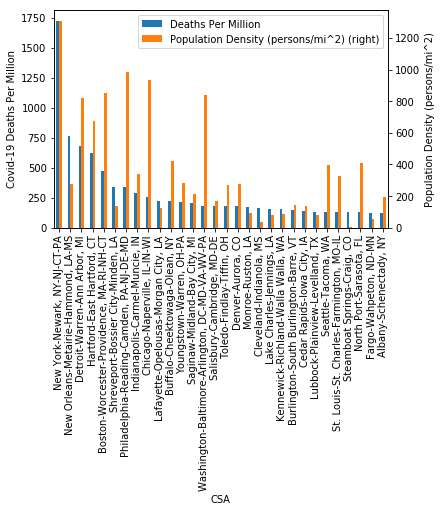

In [13]:
### Graph of CSA Deaths Per Million verse Population Densitiy, with Deaths Per Million Sorted From Highest###
frameForGraph = (
    covidDeathAnalysis_CSA
    .set_index('CSA')
    .sort_values(by='Deaths Per Million', ascending=False)
    [0:30]
    )
frameForGraph[['Deaths Per Million', 'Population Density (persons/mi^2)']].plot(kind='bar', secondary_y= 'Population Density (persons/mi^2)', rot=90)
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylabel('Covid-19 Deaths Per Million')
ax2.set_ylabel('Population Density (persons/mi^2)')
plt.show()


In [14]:
### Interactive Graph of CSA Deaths Per Million verse Population Densitiy, with Deaths Per Million Sorted From Highest###
frameForGraph = (
    covidDeathAnalysis_CSA
    .sort_values(by='Deaths Per Million', ascending=False)
    #[0:30]
    )

fig = go.Figure(data=[
    go.Bar(name='Covid Deaths Per Million', x=frameForGraph['CSA'], y=frameForGraph['Deaths Per Million']),
    go.Bar(name='Population Density (persion/mi^2)', x=frameForGraph['CSA'], y=frameForGraph['Population Density (persons/mi^2)'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

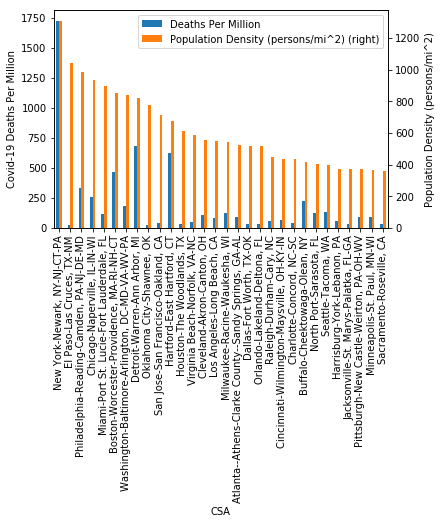

In [15]:
### Graph of CSA Deaths Per Million verse Population Densitiy, with Population Density Sorted From Highest ###
frameForGraph = (
    covidDeathAnalysis_CSA
    .set_index('CSA')
    .sort_values(by='Population Density (persons/mi^2)', ascending=False)
    [0:30]
    )
frameForGraph[['Deaths Per Million', 'Population Density (persons/mi^2)']].plot(kind='bar', secondary_y= 'Population Density (persons/mi^2)', rot=90)
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylabel('Covid-19 Deaths Per Million')
ax2.set_ylabel('Population Density (persons/mi^2)')
plt.show()


In [16]:
### Interactive Graph of CSA Deaths Per Million verse Population Densitiy, with Population Density Sorted From Highest ###
frameForGraph = (
    covidDeathAnalysis_CSA
    .sort_values(by='Population Density (persons/mi^2)', ascending=False)
    #[0:30]
    )

fig = go.Figure(data=[
    go.Bar(name='Covid Deaths Per Million', x=frameForGraph['CSA'], y=frameForGraph['Deaths Per Million']),
    go.Bar(name='Population Density (persons/mi^2)', x=frameForGraph['CSA'], y=frameForGraph['Population Density (persons/mi^2)'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [ ]:
### Plot Trying to show if there is a correlation between the overall deaths per million in 2018 ###
### verse the deaths per million from coronavirus.                                               ###

covidDeathAnalysis_CSA.plot.scatter(x ='2018 Deaths Per Million', y= 'Deaths Per Million')
plt.show()

In [ ]:
### Plot showing the coronavirus deaths per million for the 30 most populated CSA's, in descending order of population ###
coivdDeathsPlotPersonsPerMillion = (
    covidDeathAnalysis_CSA
    .set_index('CSA')
    .sort_values(by='population', ascending=False)
    [0:30][['Deaths Per Million']]
    .plot.bar()
    )
plt.show()



In [ ]:

#### Trying to work through deaths/day and scaling for population, and showing graphs with deaths per day as a time series ###




covidDeathsByMetro = countyAndCsaData.groupby('CSA', as_index=False).agg({'deaths': 'sum'}).sort_values('deaths')

removeLeadingDot = lambda s: s[1:] if (s[0] == '.') else s
removeTrailingCsa = lambda s: str(s).replace(" CSA", "")
csaData = pd.read_excel(resourcesPath + '//csaData.xlsx')
csaData['CSA'] = csaData['CSA'].apply(removeLeadingDot)
csaData['CSA'] = csaData['CSA'].apply(removeTrailingCsa)

covidDeathsByMetroWithPopulation = (
    pd.merge(covidDeathsByMetro,
             csaData,
             on = "CSA",
             how="left")
    )

covidDeathsByMetroWithPopulation['Deaths_Per_Million'] = covidDeathsByMetroWithPopulation['deaths'] /(covidDeathsByMetroWithPopulation['Population'] / 1000000)
covidDeathsByMetroWithPopulation = covidDeathsByMetroWithPopulation.sort_values('Deaths_Per_Million')

csaPopulations = countyAndCsaData.groupby('CSA', as_index=True).agg({'population': 'sum'})

groupedByCsaWithTsDeaths = list()

groupedByCsa = countyAndCsaData.groupby('CSA')

for csa, group in groupedByCsa:
    intermediate = (
        group
        .groupby('date', as_index=False)
        .agg({'deaths': 'sum'})
        .sort_values('date', ascending = 'false')
        )
    intermediate['deaths each day'] = intermediate['deaths'].diff()
    intermediate['deaths per day (moving)'] =  intermediate['deaths each day'].rolling(window = 7).mean()
    intermediate['death rate'] = intermediate['deaths per day (moving)'].diff()
    intermediate['death rate (moving)'] = intermediate['death rate'].rolling(window = 7).mean()
    
    for index, row in intermediate.iterrows():
        groupedByCsaWithTsDeaths.append((csa, intermediate.iloc[index]['date'], intermediate.iloc[index]['deaths'], intermediate.iloc[index]['deaths each day'], intermediate.iloc[index]['deaths per day (moving)'], intermediate.iloc[index]['death rate (moving)']))
        
groupedByCsaWithTsDeaths = pd.DataFrame(groupedByCsaWithTsDeaths, columns=['CSA', 'date', 'deaths', 'deaths each day', 'deaths per day (moving)', 'death rate'])
for index, row in groupedByCsaWithTsDeaths.iterrows():
    if pd.isnull(groupedByCsaWithTsDeaths.at[index, 'deaths each day']):
        groupedByCsaWithTsDeaths.at[index, 'deaths each day'] = groupedByCsaWithTsDeaths.at[index, 'deaths']
    
groupedByCsaWithTsDeaths[0:5]


In [ ]:
### Graph showing the 7 day average of the first derivative of deaths per day ###
### in other words, this is a graph of the slope of the moving average of deaths per day ###
### Positive values show that that the deaths per day is increasing with time ###
### negative values show that the deaths per day is decreasing ###
### I believe that if the values are staying in the negatives, that the peak of the coronavirus deaths has been reached ###

boston = groupedByCsaWithTsDeaths.loc[groupedByCsaWithTsDeaths['CSA'] == "Boston-Worcester-Providence, MA-RI-NH-CT"]
df = boston[['date', 'death rate']]
fig = px.line(df, x="date", y="death rate")
fig.show()

In [ ]:
groupedByCsaWithTsDeaths_ = (
    pd.merge(
    groupedByCsaWithTsDeaths,
    csaPopulations,
    on = 'CSA',
    how = 'left'
    )
)

groupedByCsaWithTsDeaths_['death rate per million'] = groupedByCsaWithTsDeaths_['death rate']/ (groupedByCsaWithTsDeaths_['population']/1000000)
groupedByCsaWithTsDeaths_['deaths per day per million'] = groupedByCsaWithTsDeaths_['deaths per day (moving)']/(groupedByCsaWithTsDeaths_['population']/1000000)
groupedByCsaWithTsDeaths_[0:5]



In [ ]:
df = groupedByCsaWithTsDeaths_
fig = px.line(df, x="date", y="deaths per day per million", color="CSA")
fig.show()